# Patristic Text Archive – work with the texts
Python 3.7 min required

In [7]:
import os,sys,glob,re
import json
from cltk.corpus.utils.importer import CorpusImporter
from cltk.corpus.multilingual import corpora as cp
from cltk.corpus.utils.formatter import cltk_normalize
from cltk.utils.frequency import Frequency
from cltk.text_reuse.levenshtein import Levenshtein
from MyCapytain.resources.texts.local.capitains.cts import CapitainsCtsText
from MyCapytain.common.constants import Mimetypes, XPATH_NAMESPACES
from lxml.etree import tostring
#import xml.etree.ElementTree as ET
from lxml import etree as ET
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer # tokenize
from difflib import SequenceMatcher
from collatex import *
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import folium
from folium.plugins import MarkerCluster

## Import the Patristic Text Archive in CLTK

In [ ]:
# Import Greek corpora
corpus_importer = CorpusImporter('greek') 
corpus_importer.import_corpus('greek_models_cltk')
corpus_importer.import_corpus('greek_lexica_perseus')

In [ ]:
# Import PTA as Corpus
MULTILINGUAL_CORPORA = cp.MULTILINGUAL_CORPORA + [
    {'encoding': 'utf-8',
     'markup': ['xml'],
     'location': 'local',
     'type': 'text',
     'name': 'patristic_text_archive'},
]
corpus_importer = CorpusImporter('multilingual') 
#corpus_importer.import_corpus('patristic_text_archive', '~/Dokumente/projekte/PatristicTextArchive/Pre-critical_editions')

## Normalize XML-Files

In [ ]:
def normalize_tei_xml():
    xml_dir = os.path.expanduser('~/Dokumente/projekte/PatristicTextArchive/Pre-critical_editions/data/*/*/*.xml')
    xml_paths = glob.glob(xml_dir)
    # new dir
    new_dir = os.path.expanduser('~/cltk_data/multilingual/text/patristic_text_archive_xml_normalized/')
    if not os.path.isdir(new_dir):
        os.makedirs(new_dir)
    for xml_path in xml_paths:
        _, xml_name = os.path.split(xml_path)
        with open(xml_path) as file_open:    
            text = file_open.read()
            normalized_text = cltk_normalize(text)
        new_plaintext_path = os.path.join(new_dir, xml_name)
        with open(new_plaintext_path, 'w') as file_open:
            file_open.write(normalized_text)
normalize_tei_xml()

## Convert TEI-XML to plaintext

In [ ]:
def tei_xml_to_text_capitains():
    """Use MyCapitains program to convert TEI to plaintext."""
    xml_dir = os.path.expanduser('~/Dokumente/projekte/PatristicTextArchive/Pre-critical_editions/data/pta0001/*/*.xml')
    xml_paths = glob.glob(xml_dir)
    xml_paths = [path for path in xml_paths if '__cts__' not in path]

    # new dir
    new_dir = os.path.expanduser('~/cltk_data/multilingual/text/patristic_text_archive_plaintext/')
    if not os.path.isdir(new_dir):
        os.makedirs(new_dir)
    
    for xml_path in xml_paths:
        _, xml_name = os.path.split(xml_path)
        xml_name = xml_name.rstrip('.xml')
        xml_name += '.txt'

        plain_text = ''
        with open(xml_path) as file_open:
            text = CapitainsCtsText(resource=file_open)
            for ref in text.getReffs(level=len(text.citation)):
                psg = text.getTextualNode(subreference=ref, simple=True)
                psg.plaintext_string_join = "" 
                text_line = psg.export(Mimetypes.PLAINTEXT, exclude=["tei:note","tei:rdg"])
                plain_text += text_line

        new_plaintext_path = os.path.join(new_dir, xml_name)
        with open(new_plaintext_path, 'w') as file_open:
            file_open.write(plain_text)

tei_xml_to_text_capitains()

Exportierte Plaintext-Dateien können mit Voyant-Tools z.B. weiterverarbeitet werden.

## Wordcount on all files in PTA

In [1]:
import os,sys
import json
from nltk.tokenize import RegexpTokenizer # tokenize
word_breaks = RegexpTokenizer(r'\w+') # whitespace
inputdir = "/home/stockhausen/cltk_data/multilingual/text/patristic_text_archive_plaintext" 
outputdir = "/home/stockhausen/cltk_data/user_data"
daten = {} # put wordcount in dictionary
wc = []
for file in os.listdir(inputdir):
    if file.endswith('.txt'):
        source = os.path.join(inputdir, file)
        content = open(source).read().lower()
        tokens = word_breaks.tokenize(content)
        wordcount = len(tokens)
        wc.append(wordcount)
        daten[file] = wordcount    
# Print accumulated wordcount
print("Number of words in archive: "+str(sum(wc)))
# Write Wordcount in json file
with open('/home/stockhausen/cltk_data/user_data/patristic_text_archive-wordcount.json', 'w') as f:
    json.dump(daten, f, sort_keys=True)

Number of words in archive: 116778


## Word lists of all files (with frequency)

In [ ]:
freq = Frequency()
frequenz = {}
for file in os.listdir(inputdir):
    source = os.path.join(inputdir, file)
    content = open(source).read().lower()
    frequenz = freq.counter_from_str(" ".join(word_breaks.tokenize(content))) # tokenize content and then freq
    file_name = file.rstrip('.txt')
    file_name += '_words.json'
    # Write Wordcount in json file
    with open(os.path.join(outputdir, file_name), 'w') as f:
        json.dump(frequenz, f, ensure_ascii=False, sort_keys=True) # sortiert auch die Worte!

## Working with the encoded biblical references 

### Extract biblical quotations from tei-xml file

In [2]:
import os
import re
import xml.etree.ElementTree as ET
id = "pta001"
file_name = "pta0001."+id+".pta-grc1.xml"
path = os.path.expanduser('/home/stockhausen/Dokumente/projekte/PatristicTextArchive/Pre-critical_editions/data/pta0001/'+id)
source = os.path.join(path, file_name)
tree = ET.parse(source)
root = tree.getroot()
ns = {'tei': 'http://www.tei-c.org/ns/1.0'}
# title of text
title = root.find('.//tei:title', ns)
quotes = []
# only real quotes (not ref in seg type=allusion)
# case 1: ref in quote
for quote in root.findall('.//tei:p/tei:quote', ns):
    r_q = {}
    ref = quote.find('tei:ref', ns).attrib["cRef"]
    quotation = quote.text
    r_q[ref] = quotation
    quotes.append(r_q)
# case 2: ref in cit
for quote in root.findall('.//tei:cit', ns):
    r_q = {}
    ref = quote.find('tei:ref', ns).attrib["cRef"]
    quotation = quote.find('tei:quote', ns).text
    r_q[ref] = quotation
    quotes.append(r_q)
print(quotes)
# TODO: Noch nicht zu Ende

[{'GNT:2 Tm:3:16': 'Πᾶσα γραφὴ θεόπνευστος καὶ ὠφέλιμος'}, {'GNT:Jn:15:26': 'τὸ πνεῦμα τῆς ἀληθείας'}, {'GNT:1 Co:12:11': 'Πάντα γὰρ ἐνεργεῖ τὸ ἓν καὶ τὸ αὐτὸ πνεῦμα, διαιροῦν ἰδίᾳ ἑκάστῳ, καθὼς βούλεται.'}, {'LXX:Ps:51:10': 'ἐλαία κατάκαρπος'}, {'LXX:Ps:51:10': 'ἐν τῷ οἴκῳ τοῦ θεοῦ ἐλαία κατάκαρπος'}, {'GNT:Jn:6:28-29': 'Τί ποιήσομεν, ἵνα ἐργασώμεθα τὰ ἔργα τοῦ θεοῦ; '}, {'GNT:Ac:10:4': 'Κορνήλιε, αἱ προσευχαί σου καὶ αἱ ἐλεημοσύναι σου ἀνέβησαν εἰς μνημόσυνον ἐνώπιον τοῦ θεοῦ.'}, {'GNT:Ac:11:13-14': 'Πέμψον οὖν εἰς Ἰόππην '}, {'GNT:Ac:10:34-35': 'Ἐπ’ ἀληθείας καταλαμβάνομαι, ὅτι οὐκ ἔστι προσωπολήπτης ὁ θεός· ἀλλ’ ἐν παντὶ ἔθνει ὁ ποιῶν δικαιοσύνην, δεκτὸς αὐτῷ ἐστίν.'}, {'GNT:Ac:10:35': 'δεκτός ἐστι'}, {'LXX:Ps:51:10': 'ἐλαία κατάκαρπος'}, {'GNT:Mt:7:15': 'Ἐλεύσονται πρὸς ὑμᾶς ἐν ἐνδύμασι προβάτων, ἔσωθεν δέ εἰσι λύκοι ἅρπαγες.'}, {'LXX:Ps:51:10': 'ἐλαία κατάκαρπος'}, {'LXX:Ps:1:3': 'Τὸ γὰρ φύλλον αὐτοῦ'}, {'LXX:Ps:51:10': 'Ἐγὼ δὲ ὡσεὶ ἐλαία κατάκαρπος.'}, {'LXX:Is:13:13-14': 'Ἐπάνω

#### Show introducing text in "cit"-encoded quotes

In [3]:
for quote in root.findall('.//tei:cit', ns):
    quotation = quote.find('tei:ref', ns).text
    ref = quote.find('tei:ref', ns).attrib["cRef"]
    quote = quote.find('tei:quote', ns).text
    print(ref+": "+quotation+" ("+quote+")")

GNT:1 Co:1:4-5: Καὶ μαρτυρεῖ Παῦλος ὧδέ πη λέγων·  (Εὐχαριστῶ τῷ θεῷ, ὅτι ἐν παντὶ ἐπλουτίσθητε ἐν αὐτῷ, ἐν παντὶ λόγῳ καὶ πάσῃ γνώσει.)
LXX:Jr:5:4: Καὶ μαρτυρεῖ Ἱερεμίας λέγων·  (Καὶ εἶπον· Ἴσως πτωχοί εἰσι, διὰ τοῦτο οὐ δύνανται ἀκούειν λόγον κυρίου.)
LXX:Ps:51:10: οἷος ἦν ὁ Δαυὶδ λέγων·  (Ἐγὼ ὡσεὶ ἐλαία κατάκαρπος, ἐν τῷ οἴκῳ τοῦ θεοῦ·)
LXX:Hos:10:1: ὡς Ἱερεμίας ἔλεγε περὶ τοῦ Ἰσραήλ·  (Ἄμπελος εὐκληματοῦσα ὁ Ἰσραήλ)
LXX:Ps:51:10: ὁ δὲ προφήτης ἀγάλλεται λέγων·  (Ἐγὼ ὡσεὶ ἐλαία κατάκαρπος)
LXX:Si:10:9: Διὰ τοῦτο ὁ μέγας Ἡσαΐας πρὸς τοὺς ὑπερηφάνους φησί·  (Τί ἀλαζονεύεται γῆ καὶ σποδός;)
LXX:Ps:33:20: ὁ μακάριος Δαυὶδ περὶ μὲν τῶν δικαίων λέγει·  (Πολλαὶ αἱ θλίψεις τῶν δικαίων.)
LXX:Ex:14:31: Λέγει γὰρ ἡ γραφή·  (Ἐπίστευσέν ὁ λαὸς εἰς τὸν θεὸν καὶ εἰς τὸν Μωϋσῆν.)


### Exctract biblical *reference* from tei-xml file

In [4]:
id = "pta049"
file_name = "pta0001."+id+".pta-grc1.xml"
path = os.path.expanduser('/home/stockhausen/Dokumente/projekte/PatristicTextArchive/Pre-critical_editions/data/pta0001/'+id)
source = os.path.join(path, file_name)
tree = ET.parse(source)
root = tree.getroot()
ns = {'tei': 'http://www.tei-c.org/ns/1.0'}
# title of text
title = root.find('.//tei:title', ns)
quotes = []
# only real quotes (not ref in seg type=allusion)
# case 1: ref in quote
for quote in root.findall('.//tei:quote/tei:ref', ns):
    ref = quote.attrib["cRef"]
    quotes.append(ref)
# case 2: ref in cit
for quote in root.findall('.//tei:cit/tei:ref', ns):
    ref = quote.attrib["cRef"]
    quotes.append(ref)
print("Datei "+file_name+" ("+title.text+") enthält "+str(len(quotes))+" biblische Zitate.")

Datei pta0001.pta049.pta-grc1.xml (Digital text of Severianus Gabalensis, De caeco nato) enthält 130 biblische Zitate.


### Extract all AT quotes

In [5]:
AT = [s for s in quotes if "LXX" in s]
regex=re.compile("LXX:([0-9A-Za-z ]*:.*)")
AT = [a.group(1) for b in AT for a in [regex.search(b)] if a]
print("Anzahl der AT-Zitate: "+(str(len(AT))))
## extract from this list only book names and write to new list
regex=re.compile("([0-9A-Za-z ]*):.*")
AT_books = [a.group(1) for b in AT for a in [regex.search(b)] if a]
## extract from this list only book names and chapters and write to new list
regex=re.compile("([0-9A-Za-z ]*?:[0-9]+?):.*")
AT_bkch = [a.group(1) for b in AT for a in [regex.search(b)] if a]

Anzahl der AT-Zitate: 32


### Extract all NT quotes    

In [6]:
NT = [s for s in quotes if "GNT" in s]
regex=re.compile("GNT:([0-9A-Za-z ]*:.*)")
NT = [a.group(1) for b in NT for a in [regex.search(b)] if a]
print("Anzahl der NT-Zitate: "+(str(len(NT))))
## extract from this list only book names and write to new list
regex=re.compile("([0-9A-Za-z ]*):.*")
NT_books = [a.group(1) for b in NT for a in [regex.search(b)] if a]
## extract from this list only book names and chapters and write to new list
regex=re.compile("([0-9A-Za-z ]*?:[0-9]+?):.*")
NT_bkch = [a.group(1) for b in NT for a in [regex.search(b)] if a]

Anzahl der NT-Zitate: 98


### Ratio of AT/NT-quotes of all quotations

In [7]:
anteil_nt = '{:.0%}'.format(len(NT)/len(quotes))
print("Anteil der NT-Zitate an allen Zitaten: "+str(anteil_nt))
anteil_at = '{:.0%}'.format(len(AT)/len(quotes))
print("Anteil der AT-Zitate an allen Zitaten: "+str(anteil_at))
# Remove duplicates from list and count instances of quotes
# AT
at = {x:AT.count(x) for x in sorted(AT, reverse=True)} # all single quotes
at_books = {x:AT_books.count(x) for x in AT_books} # all quotes (book)
at_bkch = {x:AT_bkch.count(x) for x in sorted(AT_bkch, reverse=True)} # all books with chapter
# NT
nt = {x:NT.count(x) for x in sorted(NT, reverse=True)} # all single quotes
nt_books = {x:NT_books.count(x) for x in NT_books} # all quotes (book)
nt_bkch = {x:NT_bkch.count(x) for x in sorted(NT_bkch, reverse=True)} # all books with chapter

Anteil der NT-Zitate an allen Zitaten: 75%
Anteil der AT-Zitate an allen Zitaten: 25%


## Plot AT quotations (books)

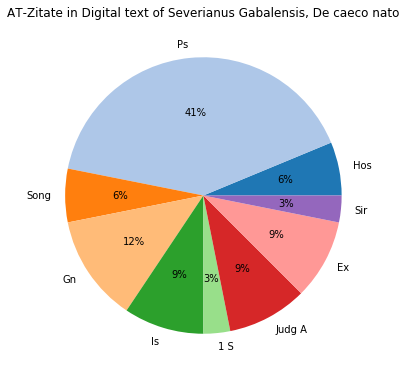

In [9]:
fig = plt.figure(1, figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.title('AT-Zitate in '+title.text)

colors = list(plt.cm.tab20(np.arange(20)))
labels = list(at_books.keys())
values = list(at_books.values())

patches, texts, autotexts = ax.pie(values, labels=labels, colors=colors, autopct='%.0f%%')

proptease = fm.FontProperties()
proptease.set_size('medium')
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)

plt.show()

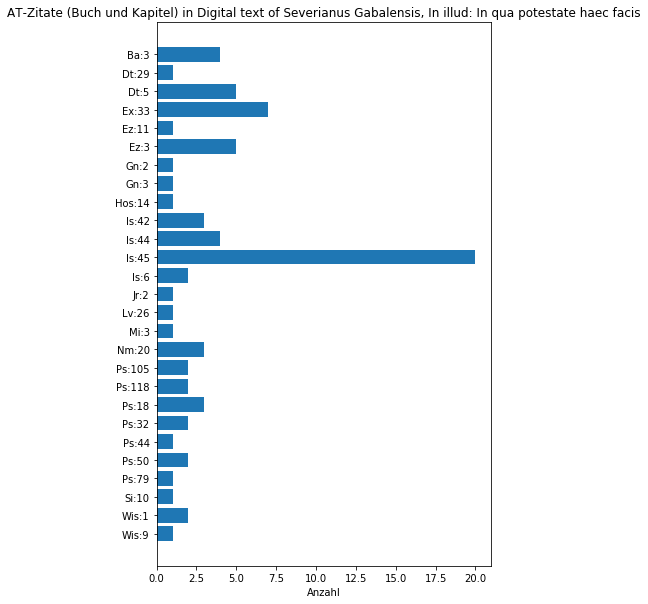

In [19]:
# AT-Zitate (Buch Kapitel) und mit absoluten Zahlen
fig = plt.figure(figsize=(6,10))
objects = list(at_bkch.keys())
y_pos = np.arange(len(objects))
performance = list(at_bkch.values())
 
plt.barh(y_pos, performance, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('Anzahl')
plt.title('AT-Zitate (Buch und Kapitel) in '+title.text)

plt.show()
# Biblical books are sorted reversed alphabetical

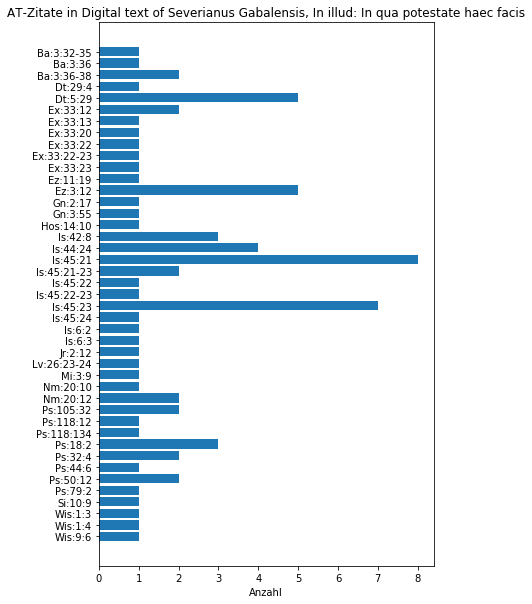

In [20]:
# AT-Zitate im einzelnen und mit absoluten Zahlen
fig = plt.figure(figsize=(6,10))
objects = list(at.keys())
y_pos = np.arange(len(objects))
performance = list(at.values())
 
plt.barh(y_pos, performance, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('Anzahl')
plt.title('AT-Zitate in '+title.text)

plt.show()
# Biblical books are sorted reversed alphabetical

## Plot NT-Quotations

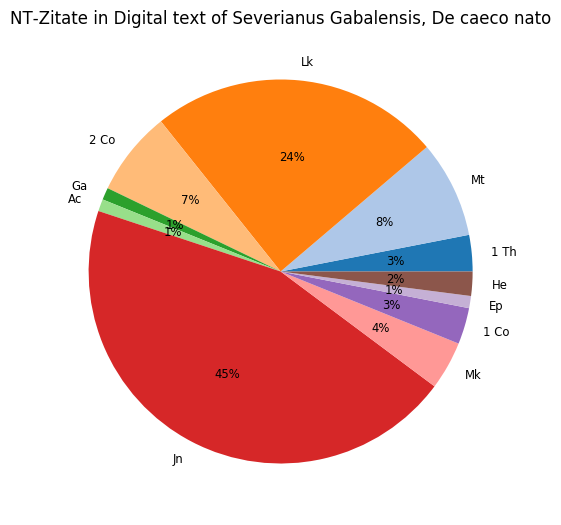

In [12]:
fig = plt.figure(1, figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.title('NT-Zitate in '+title.text)

colors = list(plt.cm.tab20(np.arange(20)))
labels = list(nt_books.keys())
values = list(nt_books.values())

patches, texts, autotexts = ax.pie(values, labels=labels, colors=colors, autopct='%.0f%%')

proptease = fm.FontProperties()
proptease.set_size('small')
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)

plt.show()

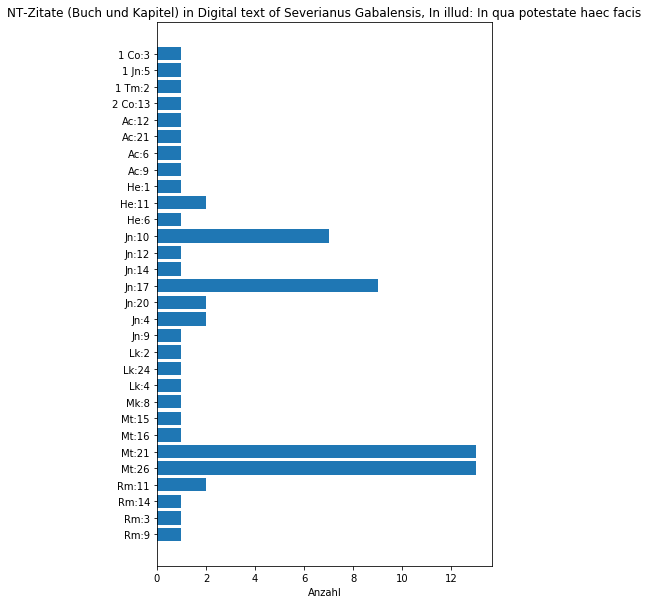

In [22]:
# NT-Zitate (Buch Kapitel) und mit absoluten Zahlen
fig = plt.figure(figsize=(6,10))
objects = list(nt_bkch.keys())
y_pos = np.arange(len(objects))
performance = list(nt_bkch.values())
 
plt.barh(y_pos, performance, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('Anzahl')
plt.title('NT-Zitate (Buch und Kapitel) in '+title.text)

plt.show()
# Biblical books are sorted reversed alphabetical

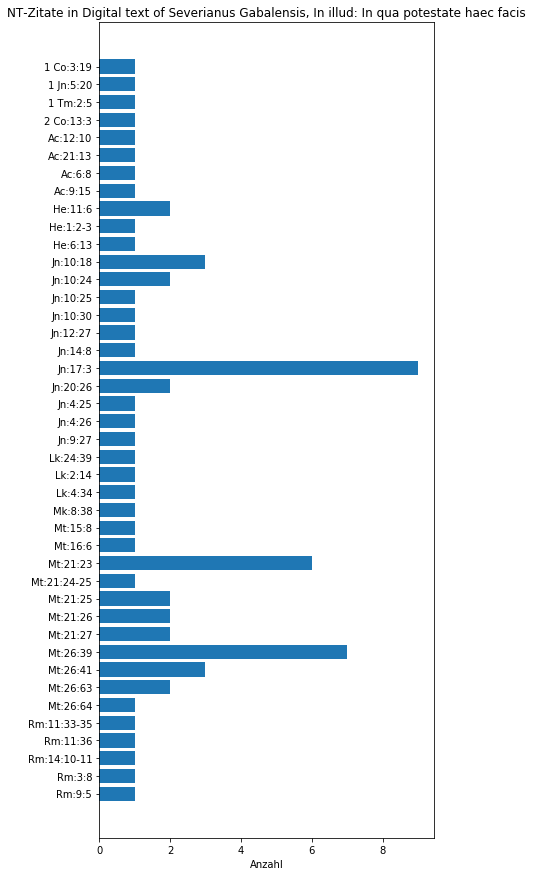

In [23]:
fig = plt.figure(figsize=(6,15))    
objects = list(nt.keys())
y_pos = np.arange(len(objects))
performance = list(nt.values())
 
plt.barh(y_pos, performance, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('Anzahl')
plt.title('NT-Zitate in '+title.text)

plt.show()

# Obsolete 
Try CLTL functions for concordance, postagging, lemmatizing.
For postagging and lemmatizing use instead `MorpheusLemmatizer`. 

In [ ]:
# Concordance
from cltk.utils import philology
pta001 = '/home/stockhausen/cltk_data/multilingual/text/patristic_text_archive_plaintext/pta0001.pta001.pta-grc1.txt'
philology.write_concordance_from_file(pta001, 'pta001')

In [ ]:
# POS-Tag file using CLTK's tagger
from cltk.tag.pos import POSTag
with open('/home/stockhausen/cltk_data/multilingual/text/patristic_text_archive_plaintext/pta0001.pta035.pta-grc1.txt', 'r') as f:
    f = f.read().lower()
tagger = POSTag('greek')
tagger.tag_tnt(f)

In [ ]:
# Lemmatize file using CLTK's lemmatizer
from cltk.stem.lemma import LemmaReplacer
with open('/home/stockhausen/cltk_data/multilingual/text/patristic_text_archive_plaintext/pta0001.pta035.pta-grc1.txt', 'r') as f:
    lemmatizer = LemmaReplacer('greek')
    f = f.read().lower()
    tokens = word_breaks.tokenize(f)
print(" – ".join(lemmatizer.lemmatize(tokens, return_raw=True)))